In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import altair as alt
import wordcloud
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
import json


## Beginning to revise raw json

First, we want to read the json into a DF named omega_raw
Then, divide duration by 60 to get minutes from seconds and make the numbers more manageable.
Then,

*   Read json in as df Omega_raw
*   Divide duration from seconds into minutes to make the numbers more manageable


*   Cast 'ts' from int into string, slice the last 5 numbers, cast back into int
*   Make a new column called 'month' and fill it depending on the ts number to translate ts into useable simulated time stamp values that we can filter our dashboard by.


*   Simplify the long 'userAgent' values into their platform names.
*   Drop the unused columns.










In [2]:
#### Convert json into df
# omega_raw = pd.read_json('bigger_listen.json', lines=True)


omega_raw = pd.read_json('bigger_listen.json', lines=True)


#### Divide duration seconds into minutes.

omega_raw['duration'] = omega_raw['duration']/60
omega_raw['duration'] = omega_raw['duration'].round()



#### Make ts smaller.
omega_raw['ts'] = omega_raw['ts'].astype(str)
omega_raw['ts'] = omega_raw['ts'].str[7:12]
omega_raw['ts'] = omega_raw['ts'].astype(int)

#### Add Month to Omega because we cant replace the ints with strings, so add new col.
omega_raw['week'] = ''

omega_raw.loc[omega_raw['ts'] <= 16666, 'week'] = 'Present'
omega_raw.loc[(omega_raw['ts'] > 16666) & (omega_raw['ts']<= 25000), 'week'] = 'Week 1'
omega_raw.loc[(omega_raw['ts'] > 25000) & (omega_raw['ts']<= 50000), 'week'] = 'Week 2'
omega_raw.loc[(omega_raw['ts'] > 50000) & (omega_raw['ts']<= 66666), 'week'] = 'Week 3'
omega_raw.loc[(omega_raw['ts'] > 66666) & (omega_raw['ts']<= 83333), 'week'] = 'Week 4'
omega_raw.loc[(omega_raw['ts'] > 83333) & (omega_raw['ts']<= 99999), 'week'] = 'Week 5'


#### Refine userAgent into easier to read values.

omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Windows' if 'Windows' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'iPad' if 'iPad' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'iPhone' if 'iPhone' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Linux' if 'X11' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Mac' if 'Macintosh' in x else x)

#### Remove unused Cols to make it easy to read.

omega_raw.drop('lon', axis=1, inplace=True)
omega_raw.drop('lat', axis=1, inplace=True)
omega_raw.drop('auth', axis=1, inplace=True)
omega_raw.drop('registration', axis=1, inplace=True)
omega_raw.drop('lastName', axis=1, inplace=True)
omega_raw.drop('itemInSession', axis=1, inplace=True)
omega_raw.drop('zip', axis=1, inplace=True)
omega_raw.drop('city', axis=1, inplace=True)

In [3]:
#### establish timezones by state.
est=["ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","DC","VA","NC","SC","GA","FL","KY","WV","OH","IN","MI"]
cst=["WI","IL","TN","AL","MS","LA","AR","MO","IA","MN","ND","SD","NE","KS","OK","TX"]
mst=["NM","CO","WY","MT","ID","UT","AZ"]
pst=["CA","WA","OR","NV"]
hst=["AK","HI"]




In [4]:
#### Refine Data into timezones.
est_df = omega_raw[omega_raw['state'].isin(est)]
cst_df = omega_raw[omega_raw['state'].isin(cst)]
mst_df = omega_raw[omega_raw['state'].isin(mst)]
pst_df = omega_raw[omega_raw['state'].isin(pst)]
hst_df = omega_raw[omega_raw['state'].isin(hst)]

## Adding TZ col to a already filtered DF seems silly, but it's to make formated printing easier later lol
#### Dont worry about the caveats below, it still works as expected andh opefully still will next week
est_df['time_zone'] = 'EST'
cst_df['time_zone'] = 'CST'
mst_df['time_zone'] = 'MST'
pst_df['time_zone'] = 'PST'
hst_df['time_zone'] = 'HST'

<ipython-input-4-984a9687d0c5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_df['time_zone'] = 'EST'
<ipython-input-4-984a9687d0c5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cst_df['time_zone'] = 'CST'
<ipython-input-4-984a9687d0c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [5]:
### Add Time_zone to omega_raw.

omega_raw['time_zone'] = ''

omega_raw.loc[omega_raw['state'].isin(est), 'time_zone'] = 'EST'
omega_raw.loc[omega_raw['state'].isin(cst), 'time_zone'] = 'CST'
omega_raw.loc[omega_raw['state'].isin(mst), 'time_zone'] = 'MST'
omega_raw.loc[omega_raw['state'].isin(pst), 'time_zone'] = 'PST'
omega_raw.loc[omega_raw['state'].isin(hst), 'time_zone'] = 'HST'

print(omega_raw)
###### Add in an Other for gender to rep other identities
others=[600,343,805,596,297,4,385,728,68,382,10,84,318,237,695,545,874,409,342,28,83,433,753,749,904,74,402,394,97,272,151,186,640,91,914,130,946,412,784,344,858,187,376,762,615,65,854,76,903,859,998,308,592,60,414,628,548,882,519,131,230,566,521,8,989,831,720,9,614,613,698,719,568,539,482,629,897,794,302,390,469,158,146,959,533,280,254,569,411,666,143,474,226,913,486,112,776,459,937,116]
for i in others:
  omega_raw.loc[omega_raw['userId'] == i, 'gender'] = 'Other'


# est_df.to_json('est_df.json', orient='records', lines=True)
# cst_df.to_json('cst_df.json', orient='records', lines=True)
# mst_df.to_json('mst_df.json', orient='records', lines=True)
# pst_df.to_json('pst_df.json', orient='records', lines=True)
# hst_df.to_json('hst_df.json', orient='records', lines=True)
# #### Rewrite revised Omega into json for streamlit side. I already have it, so quiet for now.
#omega_raw.to_json('omega_raw.json', orient='records', lines=True)





                   artist                              song  duration     ts  \
0           Ferry Corsten              Beautiful (Extended)       6.0  22205   
1                Natiruts  Jamaica Roots II(Agora E Sempre)       4.0  25305   
2                    Onyx                        Black Dust       4.0  34005   
3              The Police                         So Lonely       5.0  46305   
4            Flying Lotus                       Untitled #7       4.0  57605   
...                   ...                               ...       ...    ...   
162059  Infected Mushroom                       Heavyweight       9.0  74005   
162060              Exile                 Kiss You All Over       4.0  75905   
162061     Zac Brown Band             Chicken Fried (Album)       4.0  76005   
162062                opm                        Love Don't       3.0  81705   
162063          Kim Wilde                   Kids In America       3.0  86205   

        sessionId level state userAgent

## Revised Data is Complete

Now that we have added time zone depending on state, we can write the df into json to use in Streamlit.

<ipython-input-6-6445f6fee625>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seled_wk=pd.concat([df_seled_wk,select_tz])


      week gender  count
0  Present      M    179
1  Present      F    159
2  Present  Other     39
3   Week 5      M    276
4   Week 5      F    242
5   Week 5  Other     60


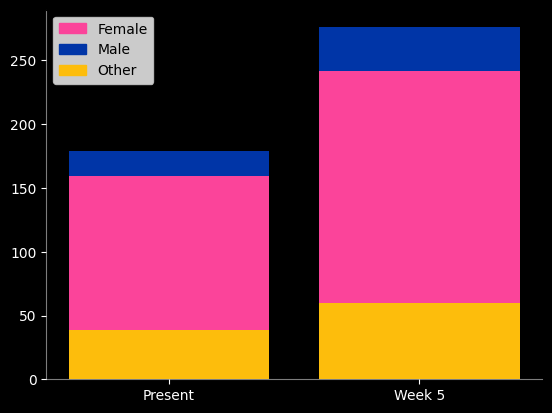

In [6]:
#### Old hard-coded methods

# #### unique user IDs and their genders
# est_gender_df = est_df.groupby('userId')['gender'].first().value_counts()
# cst_gender_df = cst_df.groupby('userId')['gender'].first().value_counts()
# mst_gender_df = mst_df.groupby('userId')['gender'].first().value_counts()
# pst_gender_df = pst_df.groupby('userId')['gender'].first().value_counts()
# hst_gender_df = hst_df.groupby('userId')['gender'].first().value_counts()
# overall_gender_df = omega_raw.groupby('userId')['gender'].first().value_counts()

# print(overall_gender_df)
##### New polymorphic method!

######## This part will be in the side bar controls and change the arguments
sb_tz = ['EST','PST','CST','MST','HST']
sb_wk = ['Present','Week 5']

df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

for i in sb_tz:
  select_tz= omega_raw.loc[omega_raw['time_zone'] == i]
  df_seled_wk=pd.concat([df_seled_wk,select_tz])
df_selected_week= df_seled_wk[df_seled_wk['week'].isin(sb_wk)]


def get_gender(df_selected_week):
  ###### Step one: drop dups since we only want to count users once
  gender_df = df_selected_week.drop_duplicates(subset='userId')
  gender_df = gender_df.groupby('week')['gender'].value_counts()
  ##### Step two: Now that userId is taken care of, we can agg between just week and gender
  gender_df=gender_df.reset_index()
  ###### Chart starts now
  height=gender_df['count']
  plt.figure(facecolor="black")
  b_colors={'M':'#0035a7','F':'#fb449a','Other':'#fdbd0c'}
  colors=[b_colors[i] for i in gender_df['gender']]
  plt.bar (gender_df['week'],height,color=colors)
  ax = plt.gca()
  ax.set_facecolor("black")
  ax.spines['bottom'].set_color('#fbfbfb80')
  ax.spines['left'].set_color('#fbfbfb80')
  ax.xaxis.label.set_color('#fbfbfb80')
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(axis='y', colors='white')
  pink_patch = mpatches.Patch(color='#fb449a', label='Female')
  blue_patch = mpatches.Patch(color='#0035a7', label='Male')
  yellow_patch = mpatches.Patch(color='#fdbd0c', label='Other')
  plt.legend(handles=[pink_patch, blue_patch,yellow_patch])

  plt.show
  print(gender_df)

get_gender(df_selected_week)


#################### Saved previous code, incase re-tooling doesnt work

# def get_gender(df_selected_week):
#   gender_df = df_selected_week.groupby('userId')['gender'].first().value_counts()
#   label_tz=str(df_selected_week['time_zone'].unique()).strip('[]')
#   label_wk=str(df_selected_week['week'].unique()).strip('[]')
#   ###### Grpah code goes under here =D Feel free to edit below, just keep it part of the function
#   ax = gender_df.plot(kind='bar', stacked=True)
#   ax.set_xlabel("Gender")
#   ax.set_ylabel("Count")
#   #### The formating in the title will change depending on the selected TZ and week!
#   ax.set_title(f"Gender Counts in {label_tz} during {label_wk}")
#   plt.legend(title="Gender")
#   plt.show()

# get_gender(df_selected_week)

## test to see function changes with new input

# df_selected_tz = est_df
# selected_week='Week 10'
# df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

# get_gender(df_selected_week)


In [ ]:
# # #### What State has the most unique users?
# # uni_state_users = omega_raw.groupby('state')['userId'].nunique()
# # uni_state_users_final = uni_state_users.sort_values(ascending=False).nlargest(5)

# # #### What State in each timezone has the most unique users?
# # est_uni_state_users = est_df.groupby('state')['userId'].nunique()
# # est_uni_state_users_final = est_uni_state_users.sort_values(ascending=False).nlargest(5)

# # cst_uni_state_users = cst_df.groupby('state')['userId'].nunique()
# # cst_uni_state_users_final = cst_uni_state_users.sort_values(ascending=False).nlargest(5)

# # mst_uni_state_users = mst_df.groupby('state')['userId'].nunique()
# # mst_uni_state_users_final = mst_uni_state_users.sort_values(ascending=False).nlargest(5)

# # pst_uni_state_users = pst_df.groupby('state')['userId'].nunique()
# # pst_uni_state_users_final = pst_uni_state_users.sort_values(ascending=False).nlargest(5)

# # hst_uni_state_users = hst_df.groupby('state')['userId'].nunique()
# # hst_uni_state_users_final = hst_uni_state_users.sort_values(ascending=False).nlargest(5)


# ##### New Polymorphic method

# df_selected_tz = omega_raw
# selected_week='Week 1'
# df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

# def get_state_count(df_selected_week):
#   state_count = df_selected_week.groupby('state')['userId'].nunique()
#   state_count_final = state_count.sort_values(ascending=False).nlargest(5)
#   ####### You can change the graphic code here. If you want more than the top five,
#   ####### Change the number in nlargest
#   ax = state_count_final.plot(kind='bar', stacked=True)
#   ax.set_xlabel("States")
#   ax.set_ylabel("Count")
#   ax.set_title(f"Top States with Highest Number of Users in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.legend(title="Count")
#   plt.show()

# get_state_count(df_selected_week)

# df_selected_tz = cst_df
# selected_week='Week 5'
# df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

# get_state_count(df_selected_week)

import plotly.express as px

# Streamline filters and group logic
def get_state_count(omega_raw, time_zone='All', week='All'):
    df = omega_raw.copy()
    if time_zone != 'All': df = df[df['time_zone'] == time_zone]
    if week != 'All': df = df[df['week'] == week]

    groupby_cols = ['state', 'time_zone'] if week == 'All' else ['state', 'time_zone', 'week']
    state_count = df.groupby(groupby_cols)['userId'].nunique().reset_index()

    state_count.columns = ['State', 'Time Zone', 'User Count'] if week == 'All' else ['State', 'Time Zone', 'Week', 'User Count']
    hover_data = {'User Count': True, 'Time Zone': True, 'Week': True} if week != 'All' else {'User Count': True, 'Time Zone': True}

    # Create plot
    fig = px.choropleth(state_count, locations='State', locationmode='USA-states', color='User Count',
                        hover_name='State', hover_data=hover_data, color_continuous_scale="Blues",
                        title=f"User Distribution: {time_zone if time_zone != 'All' else 'All Time Zones'} | {week if week != 'All' else 'All Weeks'}")

    fig.update_geos(visible=True, showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="lightgray", projection_type="albers usa")
    fig.show()

# Call the function with your dataset and filters
#get_state_count(omega_raw, 'All', 'Week 4')
# get_state_count(omega_raw, 'All', 'All')
# get_state_count(omega_raw, 'PST', 'Week 2')
get_state_count(omega_raw, 'MST', 'All')
# get_state_count(omega_raw, 'CST', 'Week 1')

# Check if specific state exists (e.g., 'OK')
state_exists = omega_raw['state'].eq('OK').any()
print(f"Does state 'OK' exist? {state_exists}")


In [ ]:
#### What song was most listened to in each timezone?

#### Old hard-coded methods that only filtered by tz
# est_most_played = est_df['song'].value_counts().nlargest(10)
# cst_most_played = cst_df['song'].value_counts().nlargest(10)
# mst_most_played = mst_df['song'].value_counts().nlargest(10)
# pst_most_played = pst_df['song'].value_counts().nlargest(10)
# hst_most_played = hst_df['song'].value_counts().nlargest(10)
# overall_most_played = omega_raw['song'].value_counts().nlargest(10)

##### New polymorphic method! (First one I tried)

######## This part will be in the side bar controls and change the arguments
df_selected_tz = pst_df
selected_week='Week 1'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]


# total_dur=omega_raw['duration'].sum()
# total_uni=omega_raw['userId'].nunique()
mpad=df_selected_week.groupby('artist')['duration'].sum()
mpad=mpad.sort_values(ascending=False).reset_index(drop=False)
print(mpad)

mpa=df_selected_week['artist'].value_counts().head(10)
mpa=mpa.sort_values(ascending=False).reset_index(drop=False)
print("")
print("mpa")
print("")
print(mpa)
##########Graph
def most_played(df_selected_week):
  mps=df_selected_week['song'].value_counts().nlargest(10)
  ####### You can change the graphic code under here for whatever style, just
  ####### leave the above code unchanged.
  ax = mps.plot(kind='bar')
  ax.set_xlabel("Song")
  ax.set_ylabel("Count")
  ax.set_title(f"Most Listned to in {df_selected_tz.iloc[1,12]} in {selected_week}")
  plt.legend(title="Songs")
  plt.show()




most_played(df_selected_week)

df_selected_tz = est_df
selected_week='Week 5'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

most_played(df_selected_week)




In [ ]:
# #### What artist was most listened to in each timezone?

# est_most_played_artist = est_df['artist'].value_counts().nlargest(10)
# cst_most_played_artist = cst_df['artist'].value_counts().nlargest(10)
# mst_most_played_artist = mst_df['artist'].value_counts().nlargest(10)
# pst_most_played_artist = pst_df['artist'].value_counts().nlargest(10)
# hst_most_played_artist = hst_df['artist'].value_counts().nlargest(10)
# overall_most_played_artist = omega_raw['artist'].value_counts().nlargest(10)
# print(overall_most_played_artist)


##### Polymorphic method
df_selected_tz = est_df
selected_week='Week 2'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

def most_played_artist(df_selected_week):
  mpa=df_selected_week['artist'].value_counts().nlargest(10)
  ax = mpa.plot(kind='bar', stacked=True)
  ax.set_xlabel("Artists")
  ax.set_ylabel("Count")
  ax.set_title(f"Most Listned to Artist in {df_selected_tz.iloc[1,12]} in {selected_week}")
  plt.legend(title="Artists")
  plt.show()

most_played_artist(df_selected_week)

df_selected_tz = hst_df
selected_week='Week 3'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

most_played_artist(df_selected_week)


In [ ]:
# #### What artist was most listened to in each timezone?

# est_most_played_artist = est_df['artist'].value_counts().nlargest(10)
# cst_most_played_artist = cst_df['artist'].value_counts().nlargest(10)
# mst_most_played_artist = mst_df['artist'].value_counts().nlargest(10)
# pst_most_played_artist = pst_df['artist'].value_counts().nlargest(10)
# hst_most_played_artist = hst_df['artist'].value_counts().nlargest(10)
# overall_most_played_artist = omega_raw['artist'].value_counts().nlargest(10)
# print(overall_most_played_artist)


##### Polymorphic method
df_selected_tz = est_df
selected_week='Week 5'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

def most_played_artist(df_selected_week):
  mpa=df_selected_week['artist'].value_counts()
  # ax = mpa.plot(kind='bar', stacked=True)
  # ax.set_xlabel("Artists")
  # ax.set_ylabel("Count")
  # ax.set_title(f"Most Listned to Artist in {df_selected_tz.iloc[1,12]} in {selected_week}")
  # plt.legend(title="Artists")
  # plt.show()
  plt.figure(figsize=(10, 7))
  wc = WordCloud(background_color='white', colormap='winter').generate_from_frequencies(mpa)
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

most_played_artist(df_selected_week)

df_selected_tz = hst_df
selected_week='Week 3'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

most_played_artist(df_selected_week)


In [ ]:
# #### What platforms are most used per timezone?
# platform_overall=omega_raw.groupby('userId')['userAgent'].first().value_counts()
# platform_est = est_df.groupby('userId')['userAgent'].first().value_counts()
# platform_cst = cst_df.groupby('userId')['userAgent'].first().value_counts()
# platform_mst = mst_df.groupby('userId')['userAgent'].first().value_counts()
# platform_pst = pst_df.groupby('userId')['userAgent'].first().value_counts()
# platform_hst = hst_df.groupby('userId')['userAgent'].first().value_counts()
# print(platform_overall)

df_selected_tz = pst_df
selected_week='Week 4'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

def most_used_platform(df_selected_week):
  platform=df_selected_week.groupby('userId')['userAgent'].first().value_counts()
  ############## Graph
  # ax = platform.plot(kind='bar', stacked=True)
  # ax.set_xlabel("Platforms")
  # ax.set_ylabel("Count")
  # ax.set_title(f"Most Used Platforms in {df_selected_tz.iloc[1,12]} in {selected_week}")
  # plt.legend(title="Platforms")
  # plt.show()

  # ###Pie Chart
  # fig = plt.figure(figsize=(10, 7))
  # plt.pie(platform, labels=platform.index, autopct='%1.1f%%')
  # plt.title(f"Most Used Platforms in {df_selected_tz.iloc[1,12]} in {selected_week}")
  # plt.show()

  ##Donut Chart
  fig = px.pie(platform, names=platform.index, values=platform, hole=.6)
  fig.update_traces(textinfo='percent+label')
  fig.update_layout(title_text=f"Most Used Platforms in {df_selected_tz.iloc[1,12]} in {selected_week}")
  fig.show()


most_used_platform(df_selected_week)

df_selected_tz = cst_df
selected_week='Week 3'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

most_used_platform(df_selected_week)

      Week Level  Count
0  Present  free    283
1  Present  paid     61
2   Week 1  free    122
3   Week 1  paid     27


<ipython-input-25-1f46e284511a>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seled_wk=pd.concat([df_seled_wk,select_tz])


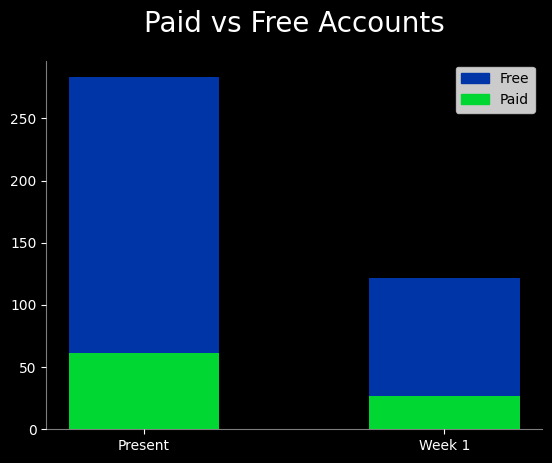

In [25]:
# #### What Paid Level is most common per time zone?

# overall_paid_level=omega_raw.groupby('userId')['level'].first().value_counts()
# est_paid_level = est_df.groupby('userId')['level'].first().value_counts()
# cst_paid_level = cst_df.groupby('userId')['level'].first().value_counts()
# mst_paid_level = mst_df.groupby('userId')['level'].first().value_counts()
# pst_paid_level = pst_df.groupby('userId')['level'].first().value_counts()
# hst_paid_level= hst_df.groupby('userId')['level'].first().value_counts()
# print(overall_paid_level)

# sb_tz = ['EST','PST','CST','MST','HST']
sb_tz = ['EST']
sb_wk = ['Present','Week 1']

df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

for i in sb_tz:
  select_tz= omega_raw.loc[omega_raw['time_zone'] == i]
  df_seled_wk=pd.concat([df_seled_wk,select_tz])
df_selected_week= df_seled_wk[df_seled_wk['week'].isin(sb_wk)]

def paid_level(df_selected_week):
  paidlev=df_selected_week.drop_duplicates(subset=['userId'])
  paidlev=paidlev.groupby('week')['level'].value_counts()
  paidlev=paidlev.reset_index()
  paidlev.columns = ['Week', 'Level', 'Count']
  print(paidlev)
  #######
  height=paidlev['Count']
  plt.figure(facecolor="black")
  b_colors={'paid':'#00d732','free':'#0035a7'}
  colors=[b_colors[i] for i in paidlev['Level']]
  plt.bar (paidlev['Week'],height,color=colors,width=0.5)
  ax = plt.gca()
  ax.set_facecolor("black")
  ax.spines['bottom'].set_color('#fbfbfb80')
  ax.spines['left'].set_color('#fbfbfb80')
  ax.xaxis.label.set_color('#fbfbfb80')
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(axis='y', colors='white')
  ax.set_title("Paid vs Free Accounts", fontsize=20, pad=20,color='white')
  pink_patch = mpatches.Patch(color='#00d732', label='Paid')
  blue_patch = mpatches.Patch(color='#0035a7', label='Free')
  plt.legend(handles=[blue_patch,pink_patch])
  plt.show()

########### Old graph/function incase refactor is a bust
# def paid_level(df_selected_week):
#   paidlev=df_selected_week.drop_duplicates(subset='userId')
#   paidlev=df_selected_week.groupby('userId')['level'].first().value_counts()
#   ########
#   ax = paidlev.plot(kind='barh', stacked=True)
#   ax.set_xlabel("Count")
#   ax.set_ylabel("Level")

#   ax.set_title(f"Paid vs Free Accounts in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.legend(title="Levels")
#   plt.show()

paid_level(df_selected_week)



<ipython-input-27-4c1719f2ed95>:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seled_wk=pd.concat([df_seled_wk,select_tz])


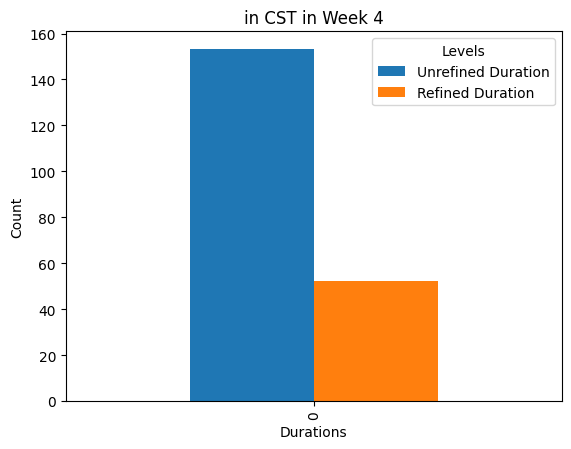

153.28


In [27]:
####### Average Hours Played per Time Zone ############
####Find outliers to make them toggle-able later

# total_dur=omega_raw['duration'].sum()
# total_uni=omega_raw['userId'].nunique()
# total_dur=total_dur/total_uni
# total_dur=total_dur.round(2)
# print("Unrefined TOTAL Average Hours IQR")
# print(total_dur)

############## Since we decided on a scatter plot, I felt it was better to drop the average portion of it
############ and show just the users and their hourly usage.



# def hours_listened_all(df_selected_week):
#   odur=df_selected_week.groupby('state')['duration'].sum()/60
#   odur=odur.round().sort_values(ascending=False)
#   odur=odur.reset_index(drop=False)
#   odur_final=odur.drop(odur[odur['duration'] == 0].index)
#   ### Finding middle section to highlight
#   # top_most=odur_final.iloc[0,1]
#   # index_third=odur.iloc[0,1]//3
#   # topnum=odur.iloc[0,1]-index_third
#   # bottomnum=odur_final.iloc[-1,1]+index_third
#   y_av=np.mean(odur_final['duration'])
#   odur_final.plot.bar('state','duration')
#   # plt.axhspan(topnum, bottomnum, color='red', alpha=0.2)
#   plt.title(f"Duration in Hours per User in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.axhline(y=y_av, color='r', linestyle='--', label='Average')
#   plt.show()



# df_selected_tz = pst_df
# selected_week='Week 3'
# df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]
# print("With Outlier")
# hours_listened_all(df_selected_week)



# def hours_listened_nout(df_selected_week):
#   #### Add up
#   total_dur=df_selected_week.groupby('state')['duration'].sum()/60
#   total_dur=total_dur.round().sort_values(ascending=False)
#   total_dur=total_dur.reset_index(drop=False)
#   ##### Find Outliers
#   q1 = total_dur.quantile(0.25)
#   q3 = total_dur.quantile(0.75)
#   IQR = q3 - q1
#   no_outliers = total_dur[(q1 - 1.5*IQR < total_dur) &  (total_dur < q3 + 1.5*IQR)]
#   #### Turn Seires into DF
#   df_no_outliers=pd.DataFrame(no_outliers)
#   print(df_no_outliers)
#   df_no_outliers=df_no_outliers.reset_index(drop=False)
#   ###### Filter with new DF to have refined and unrefied.
#   ####### Refined
#   dur_refined_sum=df_no_outliers['duration'].sum()
#   dur_reuni=df_no_outliers['state'].nunique()
#   dur_refined_av=dur_refined_sum/dur_reuni
#   dur_refined_av=dur_refined_av.round(2)
#   # Finding middle section to highlight
#   top_most=df_no_outliers.iloc[0,1]
#   index_third=df_no_outliers.iloc[0,1]//3
#   topnum=df_no_outliers.iloc[0,1]-index_third
#   bottomnum=df_no_outliers.iloc[-1,1]+index_third


#   y_av=np.mean(df_no_outliers['duration'])
#   df_no_outliers.plot.bar('state','duration')
#   # plt.axhspan(topnum, bottomnum, color='red', alpha=0.2)
#   # plt.title(f"Duration in Hours per User in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.axhline(y=y_av, color='r', linestyle='--', label='Average')
#   plt.show()



#   #### Add up
#   total_dur=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False

#   #### Add up
#   total_dur=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False)
#   #### Average
#   dur_unrefined=df_selected_week['duration'].sum()
#   dur_unrefined_uni=df_selected_week['userId'].nunique()
#   dur_unrefined=dur_unrefined/dur_unrefined_uni
#   dur_unrefined=dur_unrefined.round(2)
#   print(dur_unrefined)
#   ##### make into DF
#   # df_dur_unrefined=pd.DataFrame(dur_unrefined)
#   # df_dur_unrefined=df_dur_unrefined.reset_index(drop=False)
#   ###### Graph
#   # plt.scatter(dur_unrefined)
#   # plt.show()
#   ax = dur_unrefined.plot(kind='bar')
#   ax.set_xlabel("Durations")
#   ax.set_ylabel("Count")
#   ax.set_title(f"Unrefined Average Duration in Hours in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.legend(title="Levels")
#   plt.show()

# def no_outlier_duration(df_selected_week):
#   #### Add up
#   total_dur=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False)
#   ##### Find Outliers
#   q1 = total_dur.quantile(0.25)
#   q3 = total_dur.quantile(0.75)
#   IQR = q3 - q1
#   no_outliers = total_dur[(q1 - 1.5*IQR < total_dur) &  (total_dur < q3 + 1.5*IQR)]
#   #### Turn Seires into DF
#   df_no_outliers=pd.DataFrame(no_outliers)
#   df_no_outliers=df_no_outliers.reset_index(drop=False)
#   ###### Filter with new DF to have refined and unrefied.
#   ####### Refined
#   dur_refined_sum=df_no_outliers['duration'].sum()
#   dur_reuni=df_no_outliers['userId'].nunique()
#   dur_refined_av=dur_refined_sum/dur_reuni
#   dur_refined_av=dur_refined_av.round(2)
#   ###### Grpah
#   # plt.scatter(dur_refined_av)
#   # plt.show()
#   ax = dur_refined_av.plot(kind='bar')
#   ax.set_xlabel("Durations")
#   ax.set_ylabel("Count")
#   ax.set_title(f"Refined Average Duration in Hours in {df_selected_tz.iloc[1,12]} in {selected_week}")
#   plt.legend(title="Levels")
#   plt.show()


# def av_duration(df_selected_week):
#   if yes_outliers == True:
#     outlier_duration(df_selected_week)
#   else:
#     no_outlier_duration(df_selected_week)

# av_duration(df_selected_week)

# df_selected_tz = est_df
# selected_week='Week 12'
# df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]
# yes_outliers=False
# av_duration(df_selected_week)

sb_tz = ['EST']
sb_wk = ['Present','Week 1']

df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

for i in sb_tz:
  select_tz= omega_raw.loc[omega_raw['time_zone'] == i]
  df_seled_wk=pd.concat([df_seled_wk,select_tz])
df_selected_week= df_seled_wk[df_seled_wk['week'].isin(sb_wk)]

def please(df_selected_week):
###### Original bar graph format
  ##### Get total
  total_dur=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False)
  #### Find Outliers with IQR Method
  q1 = total_dur.quantile(0.25)
  q3 = total_dur.quantile(0.75)
  IQR = q3 - q1
  no_outliers = total_dur[(q1 - 1.5*IQR < total_dur) &  (total_dur < q3 + 1.5*IQR)]
  #### Turn Seires into DF
  df_no_outliers=pd.DataFrame(no_outliers)
  df_no_outliers=df_no_outliers.reset_index(drop=False)
  ###### Filter with new DF to have refined and unrefied.
  ####### Refined
  dur_refined_sum=df_no_outliers['duration'].sum()
  dur_reuni=df_no_outliers['userId'].nunique()
  dur_refined_av=dur_refined_sum/dur_reuni
  dur_refined_av=dur_refined_av.round(2)
  ####### Unrefined
  dur_unrefined=df_selected_week['duration'].sum()
  dur_unrefined_uni=df_selected_week['userId'].nunique()
  dur_unrefined=dur_unrefined/dur_unrefined_uni
  dur_unrefined=dur_unrefined.round(2)
  ######### Concat both DFs to make a nicer chart. If this doesn't work for final graph, you can silence this and
  ######### just use the df names in the brackets [ ] and call them individually instead.
  final_dur=pd.DataFrame({'Unrefined Duration': [dur_unrefined], 'Refined Duration': [dur_refined_av]})
  ################# Graph
  ax = final_dur.plot(kind='bar')
  ax.set_xlabel("Durations")
  ax.set_ylabel("Count")
  ax.set_title(f"in {df_selected_tz.iloc[1,12]} in {selected_week}")
  plt.legend(title="Levels")
  plt.show()
  print(dur_unrefined)

please(df_selected_week)


###### Deleted other tz versions because of how large this gets.


<ipython-input-70-dd6003c6b5de>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_seled_wk=pd.concat([df_seled_wk,select_tz])


3.0
2.0
3.0
3.0
3.0
3.0


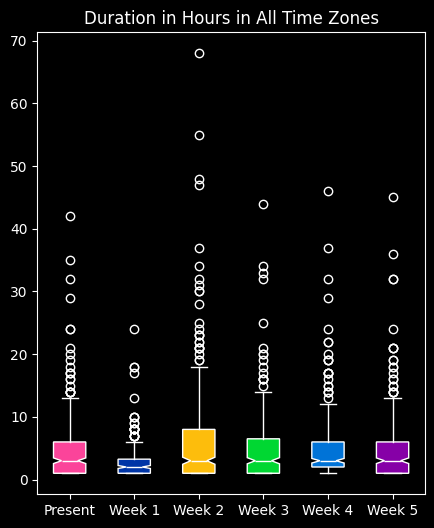

In [70]:
allPlaces=['EST','CST','MST','PST','HST']
sb_tz = allPlaces
sb_wk = ['Present','Week 1','Week 2','Week 3','Week 4','Week 5']


df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

for i in sb_tz:
  select_tz= omega_raw.loc[omega_raw['time_zone'] == i]
  df_seled_wk=pd.concat([df_seled_wk,select_tz])
df_selected_week= df_seled_wk[df_seled_wk['week'].isin(sb_wk)]

def duration(df_selected_week):
  if sb_tz==allPlaces:
        label_tz="All Time Zones"
  else:
        label_tz=sb_tz
  end=[]
  chart_y=[]
  ######################### THIS CODE IS GOOD DO NOT TOUCH
  for i in sb_wk:
    chart_y.append(i)
    total_dur=df_selected_week.loc[df_selected_week['week'] == i]
    total_dur=total_dur.groupby('userId')['duration'].sum().sort_values(ascending=False)
    total_dur=total_dur.reset_index(drop=False)
    total_dur=total_dur['duration']//60
    total_dur=total_dur[total_dur!=0]
    print(total_dur.median())
    end.append(total_dur)


  fig=plt.figure(figsize=(5,6))
  fig.set_facecolor("black")
  dur=plt.boxplot(end,notch=True,patch_artist=True)
  labels = chart_y
  plt.xticks(np.arange(1, len(end) + 1), labels)
  colors = ['#fb449a', '#0035a7', '#fdbd0c', '#00d732', '#0073d7','#8600a7']
  for patch, color in zip(dur['boxes'], colors):
    patch.set_facecolor(color)
  for median in dur['medians']:
    median.set_color('white')
  plt.title(f"Duration in Hours in {label_tz}")

  plt.show()
  #   ####################### UserID Still attached ABOVE, Removed BELOW
  #   total_dur_sum=total_dur['duration'].sum()
  #   total_dur_sum=total_dur_sum//60
  #   unrefined.append(total_dur_sum)
  #   print(total_dur)
  #   print(f"total median:{total_median}")
  #   ##### Find da Outliers
  #   q1 = total_dur.quantile(0.25)
  #   q3 = total_dur.quantile(0.75)
  #   IQR = q3 - q1
  #   no_outliers = total_dur[(q1 - 1.5*IQR < total_dur) &  (total_dur < q3 + 1.5*IQR)]
  #   refined_sum=no_outliers['duration'].sum()
  #   refined_sum=refined_sum//60
  #   refined.append(refined_sum)
  # ########################## END OF CORE LOGIC
  #   results=pd.DataFrame({i:{'Unrefined Sum': [total_dur_sum], 'Refined Sum': [refined_sum]}})
  #   resultsBig.append(results)
  #   print(results)

  # results_final=pd.concat(resultsBig)


  # fig, ax = plt.subplots()
  # plt.figure(facecolor="black")
  # plt.stackplot(chart_y,unrefined, color='#8600a7')
  # plt.stackplot(chart_y,refined, color='#0035a7')
  # ax.set_facecolor('black')

  # plt.xlim(0, len(chart_y))
  # ax.set_xticklabels(chart_y)


    #refined


duration(df_selected_week)

In [ ]:
df_selected_tz = omega_raw
selected_week='Present'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]
def leader_board(df_selected_week):
    top_boi=df_selected_week.groupby('userId')['duration']
    top_boi=top_boi.sum().sort_values(ascending=False)
    top_boi=top_boi//60
    top_boi=top_boi.reset_index(drop=False)
    top_boi=top_boi.head(3)
    best_bois=top_boi['userId'].head(3)
    best_bois=best_bois.reset_index(drop=False)
    print(best_bois)
    lb_boi=pd.DataFrame(columns=['userId','name','state','duration'])
    for i in best_bois['userId']:
      big_boi_name=df_selected_week['firstName'].loc[df_selected_week['userId']==i].head(1)
      big_boi_state=df_selected_week['state'].loc[df_selected_week['userId']==i].head(1)
      big_boi_listen=top_boi['duration'].loc[top_boi['userId']==i]
      lb_boi=pd.DataFrame({'userId': [i], 'name': [big_boi_name.iloc[0]], 'state': [big_boi_state.iloc[0]], 'duration': [big_boi_listen.iloc[0]]})
      print(lb_boi)
    # final_dur=pd.DataFrame({'Unrefined Duration': [dur_unrefined], 'Refined Duration': [dur_refined_av]})
leader_board(df_selected_week)


In [ ]:
df_selected_tz = est_df
selected_week='Week 4'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

mpad=df_selected_week.groupby('artist')['duration'].value_counts().head(10)
print(mpad)

def hours_listened(df_selected_week):
    odur=df_selected_week.groupby('userId')['duration'].sum()/60
    odur=odur.round().sort_values(ascending=False)
    odur=odur.reset_index(drop=False).head(2)

    print(odur)
hours_listened(df_selected_week)
print("wut")
def outers(df_selected_week):
  total_dur=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False)
##### Find Outliers
  q1 = total_dur.quantile(0.25)
  q3 = total_dur.quantile(0.75)
  IQR = q3 - q1
  no_outliers = total_dur[(q1 - 1.5*IQR < total_dur) &  (total_dur < q3 + 1.5*IQR)]
#### Turn Seires into DF
  df_no_outliers=pd.DataFrame(no_outliers)
  df_no_outliers=df_no_outliers.reset_index(drop=False).head(2)
  print(f"df_no_outliers:{df_no_outliers}")
###### Filter with new DF to have refined and unrefied.
####### Refined
  dur_refined_sum=df_no_outliers['duration'].sum()
  dur_reuni=df_no_outliers['userId'].nunique()
  dur_refined_av=dur_refined_sum/dur_reuni
  dur_refined_av=dur_refined_av.round(2)
  print(f"dur_refined_av:{dur_refined_av}")
  return dur_refined_av
print(f"outers:{outers(df_selected_week)}")

In [ ]:
#### Top users
df_selected_tz = est_df
selected_week='Week 4'
df_selected_week=df_selected_tz.loc[df_selected_tz['week'] == selected_week]

def find_top_week(df_selected_week):
  top_user_w=df_selected_week.groupby('userId')['duration'].sum().sort_values(ascending=False)
  print(top_user_w.head(3))
  top_user_w=top_user_w.reset_index(drop=False)
  # week_top=pd.DataFrame(coloumns=['userId','name','state','duration','topArtist','topSong'])


  # for i in range(len(top_user_w)):
  #   row=df_selected_week.loc[df_selected_week['userId'] == top_user_w.iloc[i,0]].head(1)
  #   week_top.append(row)
  # print(week_top)
   #### I will come back to this, might be a post_mvp thing Can't get it to behave how I want.


  # for i in top_user_w['userId']:
  #   finder=df_selected_week.loc[df_selected_week['userId']==i]
  #   print(finder)

find_top_week(df_selected_week)

# find_top_week(df_selected_week)
#     row = df_selected_week.iloc[i,9],df_selected_week.iloc[i,8],df_selected_week.iloc[i,6]
#     print(row)

# find_top_week(df_selected_week)


In [ ]:
sb_tz = []
sb_wk = []


# selectzTZ=df_selected_tz=omega_raw['time_zone'].isin(sb_tz)
df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

#### Have 'present as default
if sb_wk==[]:
  sb_wk=['Present']
else:
  sb_wk=sb_wk
#### If no tz, then all tz to avoid errors before selections are made.
if sb_tz==[]:
  sb_tz=['EST','CST','MST','PST','HST']
###### If selections are made, go with the selections
else:
  sb_tz=sb_tz
print(sb_tz)
print(sb_wk)
####### I dont get it, these are proven to not be NoneType.....
#### Live Streamlit is saything that NoneType is being passed to the .isin(sb_wk) but obviously its not....

#### Now that there's a df with the right tz, narrow down to the ones with the right weeks we want
for i in sb_tz:
  select_tz= omega_raw.loc[omega_raw['time_zone'] == i]
  df_seled_wk=pd.concat([df_seled_wk,select_tz])
df_selected_week= df_seled_wk[df_seled_wk['week'].isin(sb_wk)]


# for i in sb_wk:
#   df_selected_week= df_seled_wk.loc[df_seled_wk['week'] == i]
  # final_select=pd.Concat([df_seled_wk,df_selected_week])
#     df_seled_wk = df_seled_wk.append(week_rows)
# df_selected_week=pd.DataFrame(df_seled_wk, ignore_index=True)
# print(df_selected_week)

# if df_selected_week['week'].isin(['Week 2']).any():
#     print("Value 7 exists in column A")
# else:
#     print("Value 7 does not exist in column A")

# print(df_seled_wk)

In [ ]:
sb_tz = ['EST','PST']
sb_wk = ['WEEK 1','WEEK 2']
df_seled_wk =pd.DataFrame(columns=['artist', 'song','duration','ts','sessionId','level','state','userAgent','userId','firstName','gender','week','time_zone'])

